In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [92]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow',
                     columns=['pickup_datetime','passenger_count','trip_distance','total_price',
                              'service','fuel_type','maintenance','energy_consumption',
                              'fuel_cost','net_profit','trip_duration','labor','co2'])

In [93]:
df = df.sample(100000)

In [94]:
df.tail(3)

,pickup_datetime,passenger_count,trip_distance,total_price,service,fuel_type,maintenance,energy_consumption,fuel_cost,net_profit,trip_duration,labor,co2
29097488,2023-10-19 17:57:18,1,3.52,31.90,0,1,0.264,0.0880,0.080960,28.030596,0.271111,3.524444,0.0000
33869084,2023-12-02 12:11:19,1,1.36,15.68,0,2,0.204,0.0476,0.043792,14.330819,0.084722,1.101389,1.3464
3913,2023-01-01 00:38:46,1,1.12,16.10,0,0,0.280,0.1120,0.103040,14.705849,0.077778,1.011111,2.9120


Procederemos a calcular la media y la desviación estándar de las columnas: trip_distance, total_price y trip_duration. Utilizando la regla empírica (que establece que aproximadamente el 99.7% de los datos se encuentran dentro de 3 desviaciones estándar de la media) para filtrar los valores que se encuentran dentro de este rango. De esta manera, se eliminan los valores atípicos que podrían afectar negativamente el análisis de datos y el entrenamiento de modelos de machine learning.

In [95]:
print(df['trip_distance'].mean())
print(df['total_price'].mean())
print(df['trip_duration'].mean())
df.shape

3.13129472
23.983818099999997
0.21381900277777774


(100000, 13)

In [96]:
# Calcular la media y desviación estándar para cada columna
mean_trip_distance = df['trip_distance'].mean()
std_trip_distance = df['trip_distance'].std()

mean_total_price = df['total_price'].mean()
std_total_price = df['total_price'].std()

mean_trip_duration = df['trip_duration'].mean()
std_trip_duration = df['trip_duration'].std()

# Filtrar valores dentro de 3 desviaciones estándar para cada columna
df_withoutliers = df[
    (df['trip_distance'] >= mean_trip_distance - 3 * std_trip_distance) & 
    (df['trip_distance'] <= mean_trip_distance + 3 * std_trip_distance) &
    (df['total_price'] >= mean_total_price - 3 * std_total_price) & 
    (df['total_price'] <= mean_total_price + 3 * std_total_price) &
    (df['trip_duration'] >= mean_trip_duration - 3 * std_trip_duration) & 
    (df['trip_duration'] <= mean_trip_duration + 3 * std_trip_duration)
]

In [97]:
print(df_withoutliers['trip_distance'].mean())
print(df_withoutliers['total_price'].mean())
print(df_withoutliers['trip_duration'].mean())
print(df_withoutliers.shape)

2.9055517109598528
23.037766507947985
0.20355172932210025
(96817, 13)


Eliminamos las columnas con datos negativos en el precio total y la duracion del viaje.

In [98]:
df_withoutliers = df_withoutliers[df_withoutliers['total_price'] >= 0]
df_withoutliers = df_withoutliers[df_withoutliers['trip_duration'] >= 0]

## 1.0: Distribution

Text(0.5, 1.0, 'trip_duration')

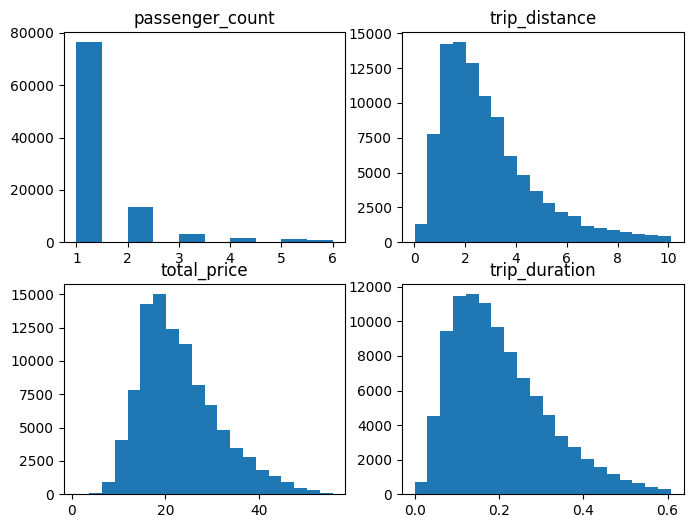

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0,0].hist(df_withoutliers['passenger_count'])
axs[0,0].set_title('passenger_count')
axs[0,1].hist(df_withoutliers['trip_distance'], bins=20)
axs[0,1].set_title('trip_distance')
axs[1,0].hist(df_withoutliers['total_price'], bins=20)
axs[1,0].set_title('total_price')
axs[1,1].hist(df_withoutliers['trip_duration'], bins=20)
axs[1,1].set_title('trip_duration')


#### 1. Cantidad de Pasajeros (passenger_count):

La mayoría de los viajes realizados en taxis o servicios de viajes compartidos en Nueva York involucran a un solo pasajero, como se observa en la marcada concentración hacia los valores más bajos en el histograma.
La demanda parece inclinarse hacia autos compactos, capaces de transportar de manera eficiente a un solo pasajero o parejas. Sin embargo, podría haber oportunidades en zonas específicas o durante eventos donde los viajes grupales puedan aumentar, lo que justificaría tener algunos vehículos más grandes disponibles.

#### 2. Distancia de Viaje (trip_distance):

La distancia promedio de los viajes tiende a ser corta, con la mayoría de los viajes ubicados por debajo de las 5 millas. Solo una minoría de viajes excede esta distancia, lo que puede reflejar la naturaleza intrínseca de la movilidad urbana, donde los viajes son mayormente locales y los usuarios optan por el taxi para trayectos cortos y rápidos.

#### 3. Tiempo del Viaje (trip_duration):
La duración de los viajes sigue una distribución similar a la distancia, con la mayoría de los trayectos durando menos de 15 minutos. Esto refleja la eficiencia de los servicios en la ciudad, donde las personas prefieren utilizar taxis para movimientos rápidos dentro de Manhattan o sus alrededores. La cola larga de la distribución sugiere la presencia de algunos viajes considerablemente más largos, posiblemente debido a factores como el tráfico o la distancia, especialmente en trayectos fuera del centro urbano.
Estos datos sobre la duración del viaje pueden ayudar a la empresa a planificar mejor los turnos de los conductores y la rotación de vehículos, así como a prever los períodos de inactividad entre los viajes.

#### 4. Precio Total (total_price):
La distribución del precio total muestra una mayoría de viajes con un costo moderado, entre $10 y $30. No obstante, algunos viajes alcanzan tarifas considerablemente más altas, lo que podría correlacionarse con viajes más largos o en horarios de alta demanda. La relación entre distancia y precio es predecible, aunque también podría haber fluctuaciones debido a factores como tarifas dinámicas o tiempos prolongados debido a congestiones de tráfico.

In [100]:
df_withoutliers.columns

Index(['pickup_datetime', 'passenger_count', 'trip_distance', 'total_price',
       'service', 'fuel_type', 'maintenance', 'energy_consumption',
       'fuel_cost', 'net_profit', 'trip_duration', 'labor', 'co2'],
      dtype='object')

Text(0.5, 1.0, 'co2')

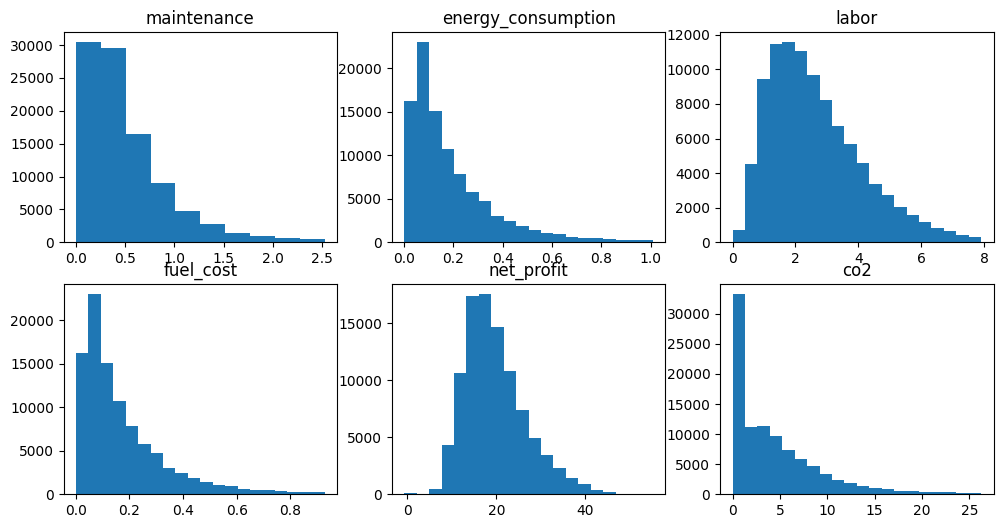

In [101]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs[0,0].hist(df_withoutliers['maintenance'])
axs[0,0].set_title('maintenance')
axs[0,1].hist(df_withoutliers['energy_consumption'], bins=20)
axs[0,1].set_title('energy_consumption')
axs[1,0].hist(df_withoutliers['fuel_cost'], bins=20)
axs[1,0].set_title('fuel_cost')
axs[1,1].hist(df_withoutliers['net_profit'], bins=20)
axs[1,1].set_title('net_profit')
axs[0,2].hist(df_withoutliers['labor'], bins=20)
axs[0,2].set_title('labor')
axs[1,2].hist(df_withoutliers['co2'], bins=20)
axs[1,2].set_title('co2')

- Mantenimiento y Consumo de Energía: Ambas variables parecen tener una distribución sesgada hacia la derecha y considerar que la mayoría de los taxis tienen costos de mantenimiento y consumo de energía relativamente bajos, pero hay un número menor de taxis con costos mucho más altos.

- Mano de Obra: La distribución de la mano de obra parece más normal, con una concentración en un rango de valores medio.

- Costo de Combustible: Similar al mantenimiento y consumo de energía, la distribución está sesgada hacia la derecha.

- Ganancia Neta: La distribución de la ganancia neta también está sesgada hacia la derecha, lo que indica que la mayoría de los taxis tienen ganancias relativamente bajas.

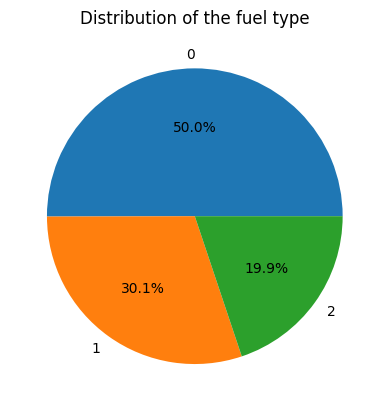

In [102]:
counts = df_withoutliers['fuel_type'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of the fuel type')
plt.show()


Existe un claro desbalanceo de clases entre los taxis que realizan viajes por fuera del distrito de Manhattan, lo que podria llegar a complicar a la hora de predecir la cantidad de viajes intra e inter distrito.

## 1.1 Correlation


In [103]:
df_withoutliers.columns

Index(['pickup_datetime', 'passenger_count', 'trip_distance', 'total_price',
       'service', 'fuel_type', 'maintenance', 'energy_consumption',
       'fuel_cost', 'net_profit', 'trip_duration', 'labor', 'co2'],
      dtype='object')

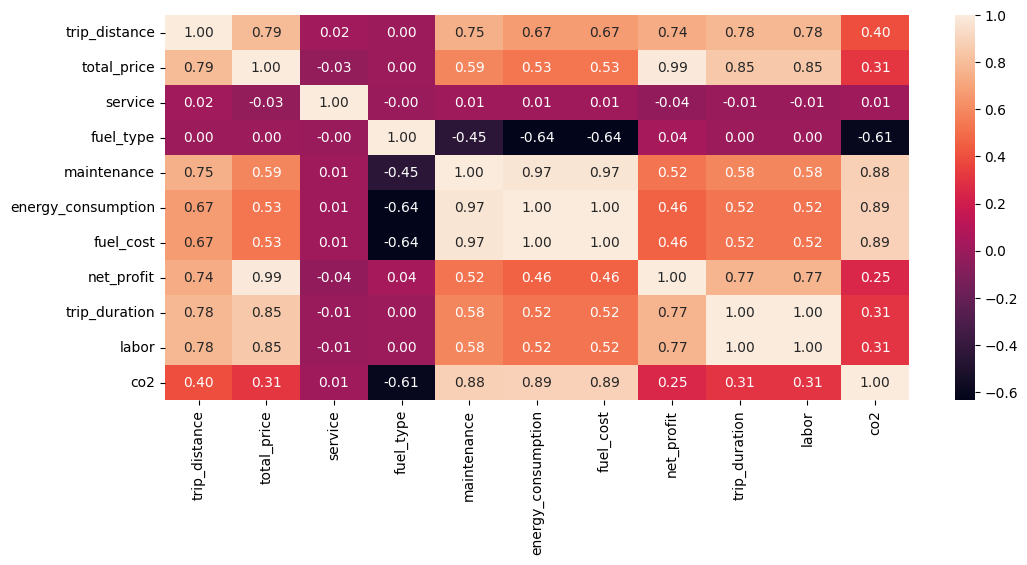

In [104]:
corr = df_withoutliers[['trip_distance', 'total_price',
       'service', 'fuel_type', 'maintenance', 'energy_consumption',
       'fuel_cost', 'net_profit', 'trip_duration', 'labor','co2']].corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

In [105]:
df_withoutliers.head(3)

,pickup_datetime,passenger_count,trip_distance,total_price,service,fuel_type,maintenance,energy_consumption,fuel_cost,net_profit,trip_duration,labor,co2
12211696,2023-04-05 07:15:55,1,6.528,34.35,0,2,0.9792,0.22848,0.210202,29.444765,0.285833,3.715833,6.46272
8622873,2023-03-28 12:33:43,1,3.088,30.46,0,1,0.2316,0.07720,0.071024,26.618487,0.272222,3.538889,0.00000
30527882,2023-11-01 08:34:35,1,2.480,15.40,0,0,0.6200,0.24800,0.228160,12.103507,0.188333,2.448333,6.44800


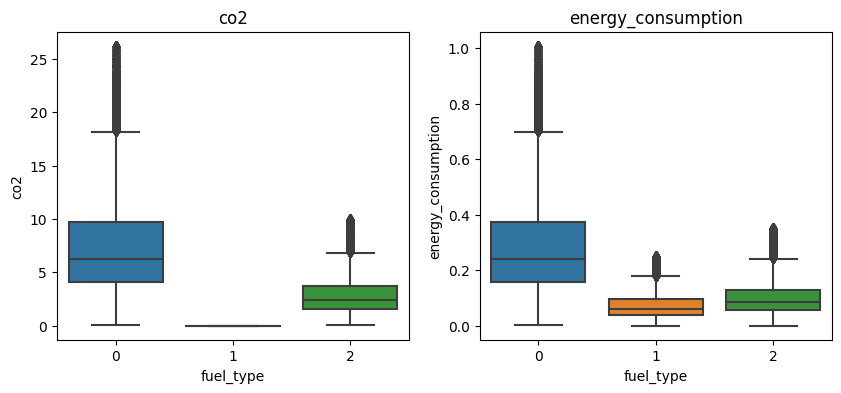

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(ax=axs[0],x='fuel_type',y='co2',data= df_withoutliers)
axs[0].set_title('co2')
sns.boxplot(ax=axs[1],x='fuel_type',y='energy_consumption',data= df_withoutliers)
axs[1].set_title('energy_consumption')
plt.show()

El análisis de los datos revela una clara influencia del tipo de combustible en las emisiones de CO2 y el consumo de energía de los taxis. Los vehículos de combustión interna (tipo 0) presentan los valores más altos y una mayor variabilidad en ambos indicadores, seguidos por los híbridos (tipo 2) y los eléctricos  (tipo 1). 

Esta tendencia sugiere que los vehículos eléctricos son los más eficientes, mientras que los de combustión interna son los menos eficientes. Sin embargo, es importante destacar la presencia de valores atípicos, especialmente en las emisiones de CO2, que podrían distorsionar ligeramente los resultados. 

Además, la distribución asimétrica de los datos indica que hay vehículos que se desvían significativamente de los valores promedio, lo cual podría atribuirse a factores como la edad del vehículo, el modelo, el tamaño del motor o las condiciones de conducción, entre otros.

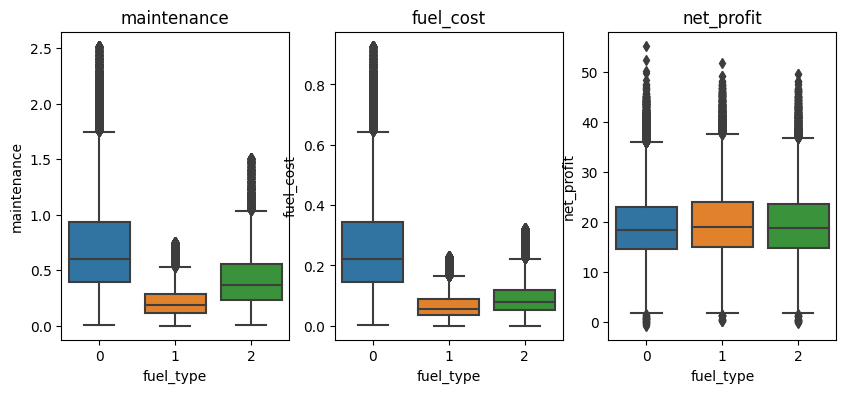

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
sns.boxplot(ax=axs[0],x='fuel_type',y='maintenance',data= df_withoutliers)
axs[0].set_title('maintenance')
sns.boxplot(ax=axs[1],x='fuel_type',y='fuel_cost',data= df_withoutliers)
axs[1].set_title('fuel_cost')
sns.boxplot(ax=axs[2],x='fuel_type',y='net_profit',data= df_withoutliers)
axs[2].set_title('net_profit')
plt.show()

La gráfica muestra que existe una variabilidad en los costos de mantenimiento y combustible, así como en las ganancias netas, según el tipo de combustible utilizado. Los boxplots revelan que, en general, los vehiculos de combustion interna(tipo 0) tienden a tener costos de mantenimiento ligeramente superiores en comparación con los otros tipos.

En cuanto al costo de combustible, también se observa una tendencia similar, sin embargo, es interesante notar que las ganancias netas parecen ser relativamente similares entre los diferentes tipos de combustible, a pesar de las variaciones en los costos.

In [108]:
# Agrupar por categoría y calcular la media
grouped = df.groupby('fuel_type')['net_profit'].mean()
print(grouped)

fuel_type
0    20.126171
1    20.965631
2    20.546758
Name: net_profit, dtype: float64


## 1.2 Time Series

In [109]:
# Extraer año, trimestre, mes, día del mes, día de la semana y hora
df['year'] = df['pickup_datetime'].dt.year
df['quarter'] = df['pickup_datetime'].dt.quarter
df['month'] = df['pickup_datetime'].dt.month
df['day_month'] = df['pickup_datetime'].dt.day
df['weekday'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour
#df.drop(columns=['pickup_datetime','dropoff_datetime'],inplace=True)